## TIMIT-derived datasets

We combina data from 2 datasets:
- TIMIT: wav
- VTRFormants: manually verified F1-3 tracks (though interpolated). A subset of TIMIT. 324 train files, 192 test files.

We can't use TIMIT-voiced (another TIMIT subset) to ensure that we are only looking at voiced speech because they only overlap in 10 samples. ~~So we use Praat's heuristics (the pulses) to determine whether there is voiced speech.~~ This is quite brittle because of boundary effects -- so we just use the phonetic information and only consider vowel events for simplicity (it's just a prior after all). In this we follow Mehta (2012), although much more restricted (they only filter out silence regions and accept consonants etc.)

### VTRFormants

Citing from the README file:

> Note that only the first three elements of these vectors (F1, F2, F3) are manually corrected.

Each frame is 10 msec.

> Note also that since interpolation was used, VTR/formant tracks are placed in silence intervals where no VTR exists. When evaluating formant trackers, these values should probably be excluded from the evaluation.

## Data cleaning

To simplify the analysis, we only compare formants during vowel events as identified by the original TIMIT database.

And we only run the Praat analysis (both pulses and formants) during these events to get clean estimates, because at the boundaries there can be strong jumps in Praat's F1-F3 formant tracks.

We also don't correct for Praat's $\hat T$ (has ~7% relative error) and thus take Praat's estimated pitch periods at face value.

We can evaluate formant tracks and ground truth anywhere (because they are both interpolated) -- maybe average them over the estimated pitch period interval.

## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

## Results

Are the Praat errors comparable to Mehta (2012, Table III)'s results? We only measure over vowels so should be quite a bit lower.

## Processing TIMIT and VTRFormants to get the training data

In [1]:
%run init.ipy

from lib import htkio
from dgf import bijectors

from vtr import formant

2022-11-03 11:34:34.946928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]4.7s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]19.4s, 0.3min   : Loading run_nested...
[Memory]20.9s, 0.3min   : Loading run_nested...
[Memory]22.4s, 0.4min   : Loading run_nested...
[Memory]23.8s, 0.4min   : Loading run_nested...
[Memory]23.9s, 0.4min   : Loading get_aplawd_training_pairs...


In [2]:
from lib.timit import *

def rand_triple():
    vtr_root = training_set(VTRFORMANTS)
    timit_root = training_set(TIMIT)
    l = list(yield_file_triples(vtr_root, timit_root))
    import random
    return random.choice(l)

triple = rand_triple()
fb_file, phn_file, wav_file = triple
triple

(PosixPath('/home/marnix/WRK/thesis/py/../data/VTRFormants/TRAIN/DR6/MSAT1/SI1073.FB'),
 PosixPath('/home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.PHN'),
 PosixPath('/home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV'))

In [3]:
d, fs = formant.read_wav_file_and_normalize(wav_file)
t = np.arange(len(d))/fs

from lib import klatt
klatt.play(t*1000., d)

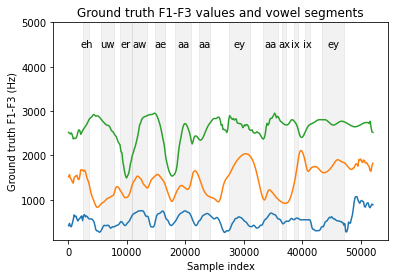

In [4]:
phn = formant.select_vowel_segments(phn_file)

def plot_vowel_segments(df, ytext):
    for start, end, label in phn.to_tuples():
        plt.axvspan(start, end, color="grey", alpha=.1)
        plt.text(start + (end - start)/2, ytext, label,
                 horizontalalignment='center',
                 verticalalignment='center')

plot_vowel_segments(phn, 4500.)
        
frame_midpoint_idx, F_true = formant.select_F_true(fb_file, fs)

plt.plot(frame_midpoint_idx, F_true)
xlabel("Sample index")
ylabel("Ground truth F1-F3 (Hz)")
title("Ground truth F1-F3 values and vowel segments")
ylim(100, 5000);

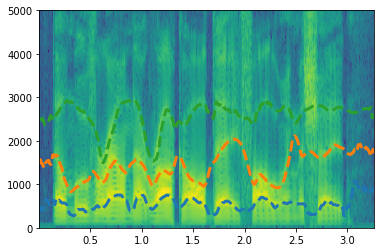

In [5]:
specgram(d, Fs=fs);
plot(frame_midpoint_idx/fs, F_true, '--', lw=3)
ylim(0, 5000);

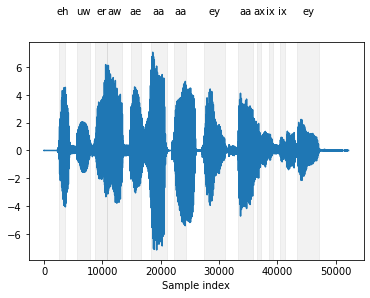

In [6]:
plot_vowel_segments(phn, 10)
plot(d)
xlabel("Sample index");

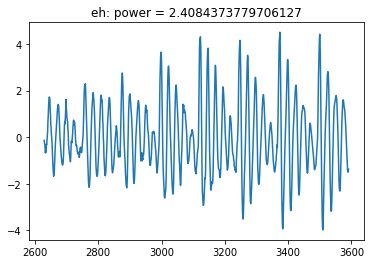

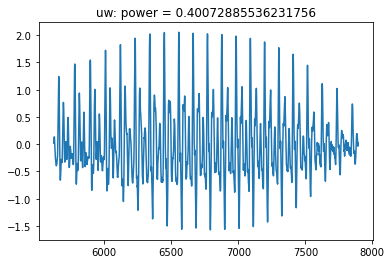

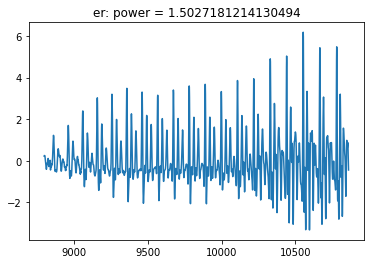

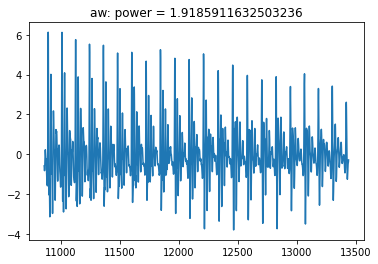

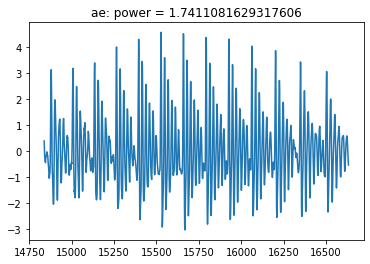

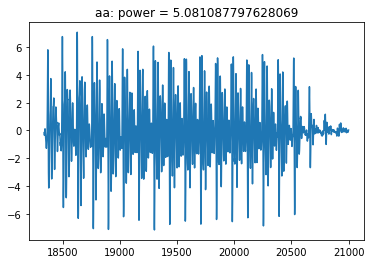

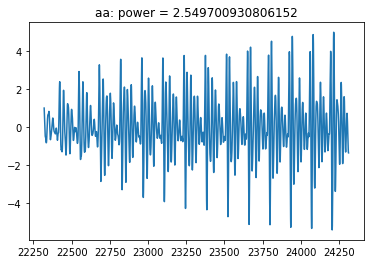

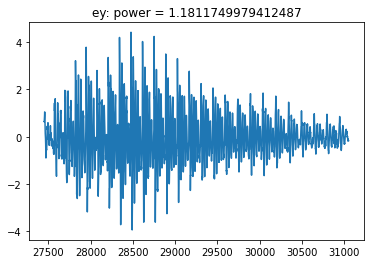

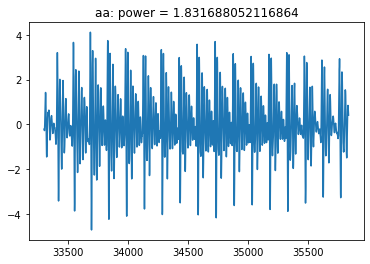

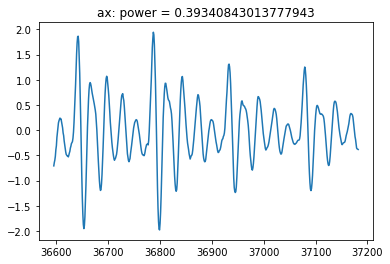

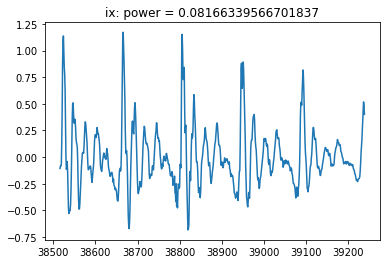

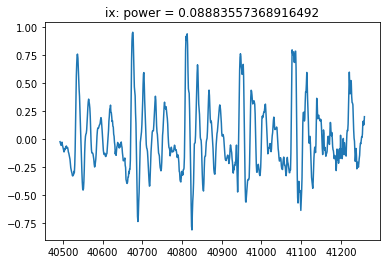

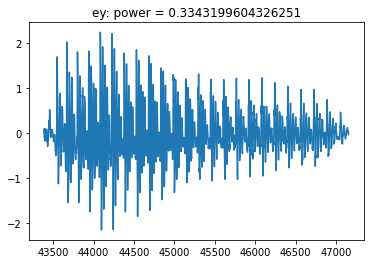

In [7]:
# Locally the power may vary, but we renormalize anyway so it doesnt matter
for start, end, label in phn.to_tuples():
    idx = range(start, end)
    segment = d[idx]
    plot(idx, segment)
    power = np.sum(segment**2)/len(segment)
    title(f'{label}: power = {power}')
    show()

**********uw**********


/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `eh` segment at sample indices 2629:3592: Praat gave only 2 < 3 valid formants
  warnings.warn(


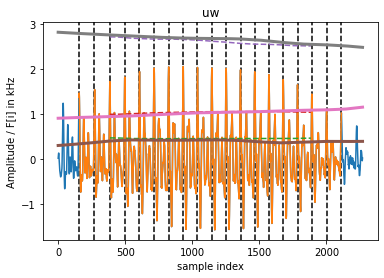

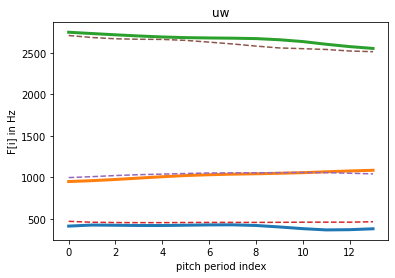

**********er**********


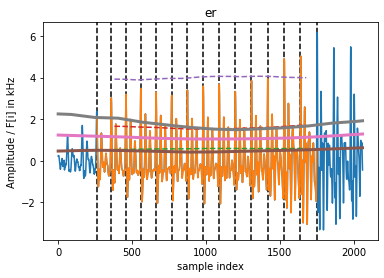

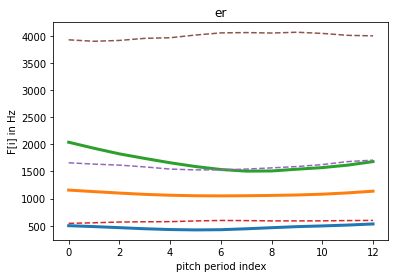

**********aw**********


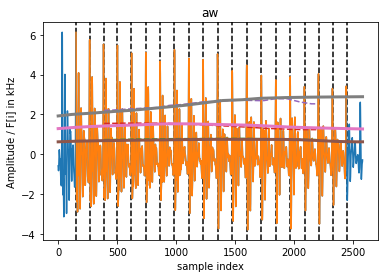

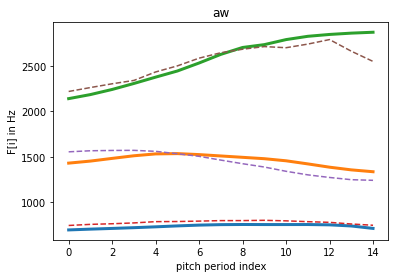

**********ae**********


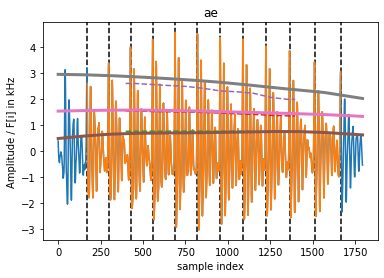

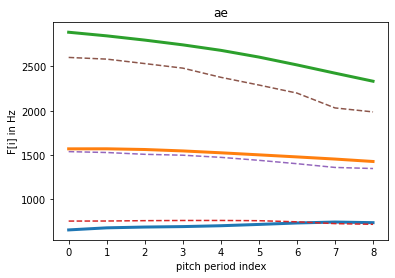

**********aa**********


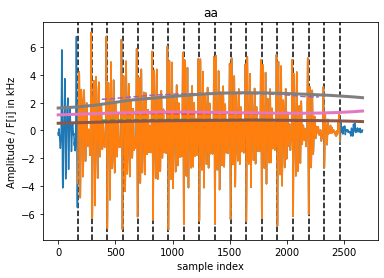

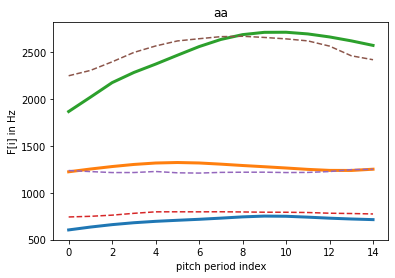

**********aa**********


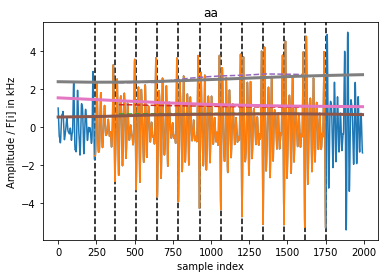

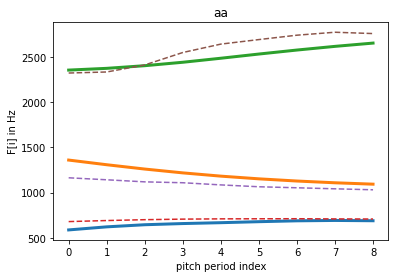

**********ey**********


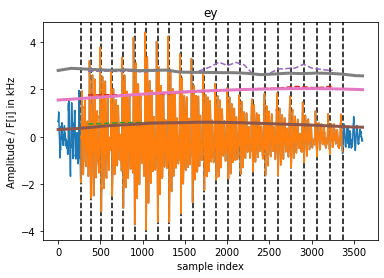

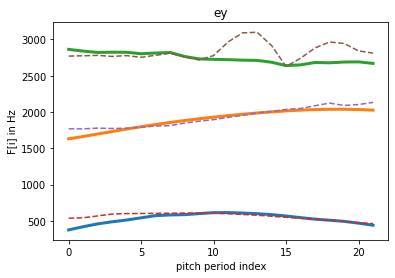

**********aa**********


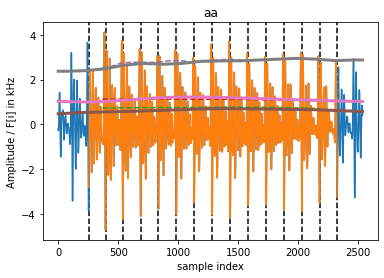

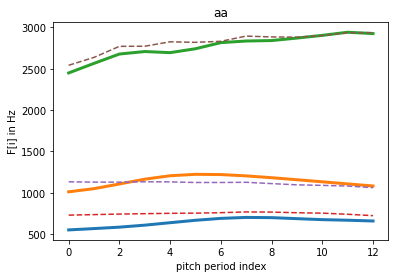

**********ey**********


/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ax` segment at sample indices 36595:37183: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 81.63265306122449 Hz.
Sound: pitch analysis not performed.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ix` segment at sample indices 38516:39240: Praat gave only 1 < 3 valid formants
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ix` segment at sample indices 40493:41260: Praat gave only 1 < 3 valid formants
  warnings.warn(


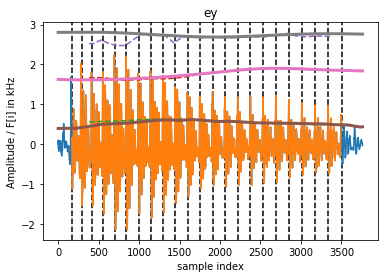

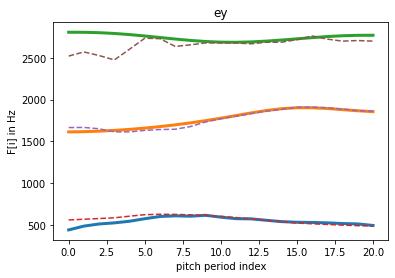

In [8]:
from lib import constants

for F_true_periods, F_praat_periods, context in formant.yield_training_pairs(
        fb_file, phn_file, wav_file, return_full=True
    ):
    vowel = context['vowel']
    print("*"*10 + vowel + "*"*10)
    
    # Plot pulse estimates
    pulse_idx = context['pulse_idx']
    for pi in pulse_idx:
        axvline(pi, ls="--", color="black")
    first, last = pulse_idx[0], pulse_idx[-1]
    
    # Plot waveform
    segment = context['segment']
    plot(segment)
    plot(range(first, last), segment[first:last])
    
    # Plot formant tracks
    plot(context['F_praat_tracks']/1000, "--")
    plot(context['F_true_tracks']/1000, lw=3)
    ylabel("Amplitude / F[i] in kHz")
    xlabel("sample index")
    title(vowel)
    show()
    
    # Plot the distilled training data
    plot(F_true_periods, lw=3)
    plot(F_praat_periods, "--")
    ylabel("F[i] in Hz")
    xlabel("pitch period index")
    title(vowel)
    show()

## Getting the training pairs

Remember, we use TIMIT/TRAIN directories so we can use testing on the TIMIT/TEST files.

With our procedure, there are 3094 valid training pairs which are typically around 10 pitch periods long with a heavy tail. Same order as the number of samples in our subset of APLAWD (5000).

In [9]:
%%time
training_pairs = formant.get_vtrformants_training_pairs()

[Memory]32.5s, 0.5min   : Loading get_vtrformants_training_pairs...
CPU times: user 233 ms, sys: 44.2 ms, total: 277 ms
Wall time: 236 ms


In [10]:
len(training_pairs)

3094

In [11]:
true_F_trajectories = [p[0] for p in training_pairs]

In [31]:
pplens = np.array([sample.shape[0] for sample in true_F_trajectories])

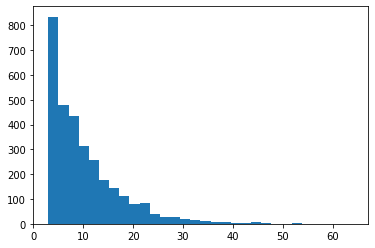

In [32]:
hist(pplens, bins=30);

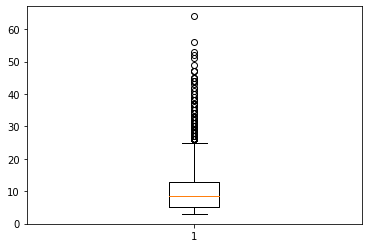

In [41]:
boxplot(pplens);

## Fitting trajectory priors

All runs take O(45) mins.

Matern32Kernel wins, with the same pattern as with the period trajectory:

- Lengthscales decrease strongly as $\nu = 1/2, 3/2, 5/2, \infty$ increases, and noise $\sigma$ increases.
- There is a strong maximum of $\log Z(\nu)$ at $\nu = 3/2$.
- There is a definite preference for the degree of smoothness (or roughness) provided by $\nu=3/2$: not too much, not too little.
- There is also a definite preferences for a lengthscale $\lambda(\nu=3/2) \simeq 15$, which is quite large, but about halfof the lengthscale for the period ($\sim 30$ pitch periods). This seems right; pitch tracks usually move slower than formant tracks.

Very small $\sigma(\nu=3/2) \simeq 0.01$ indicates very good fit. But remember, we cherry-picked all the 3094 samples for vowels. Not steady-state (since a lengthscale of 15 pitch periods is preferred) but not too wild either.

The nested sampling fits are very sharp and support the maximum likelihood approximation.

In [13]:
bounds = jnp.array([
    (100., 5000.),
    (100., 5000.),
    (100., 5000.)
])

bounds

DeviceArray([[ 100., 5000.],
             [ 100., 5000.],
             [ 100., 5000.]], dtype=float64)

In [25]:
from lib import util
NAMES = ("s1", "s2", "s3", "lengthscale", "noise_sigma")

[Memory]112.2s, 1.9min  : Loading run_nested...
Summary
nlive: 25
niter: 883
ncall: 16771
eff(%):  5.414
logz: -482458.992 +/-  1.092


None

'Information (bans)'

12.39643350757592

Quantiles:
s1 [(0.025, 1.1267834438579685), (0.5, 1.1439595007718566), (0.975, 1.1627041904386701)]
Quantiles:
s2 [(0.025, 0.9305334040082083), (0.5, 0.9437283217360487), (0.975, 0.9577427554100048)]
Quantiles:
s3 [(0.025, 0.9709002029744488), (0.5, 0.9866911033996321), (0.975, 1.0027865845800499)]
Quantiles:
lengthscale [(0.025, 171.1520216882185), (0.5, 176.0714195614432), (0.975, 180.94426026424642)]
Quantiles:
noise_sigma [(0.025, 7.229053287760507e-05), (0.5, 0.0003171469961886348), (0.975, 0.0008140339494897411)]


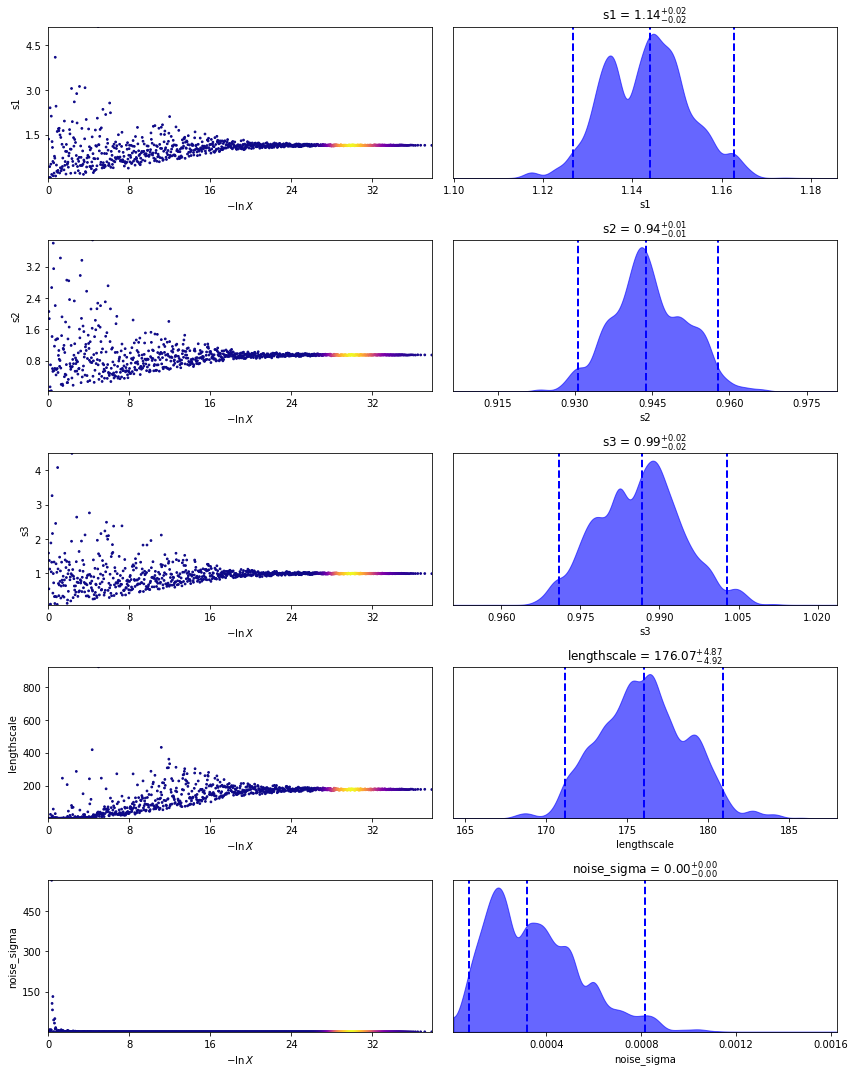

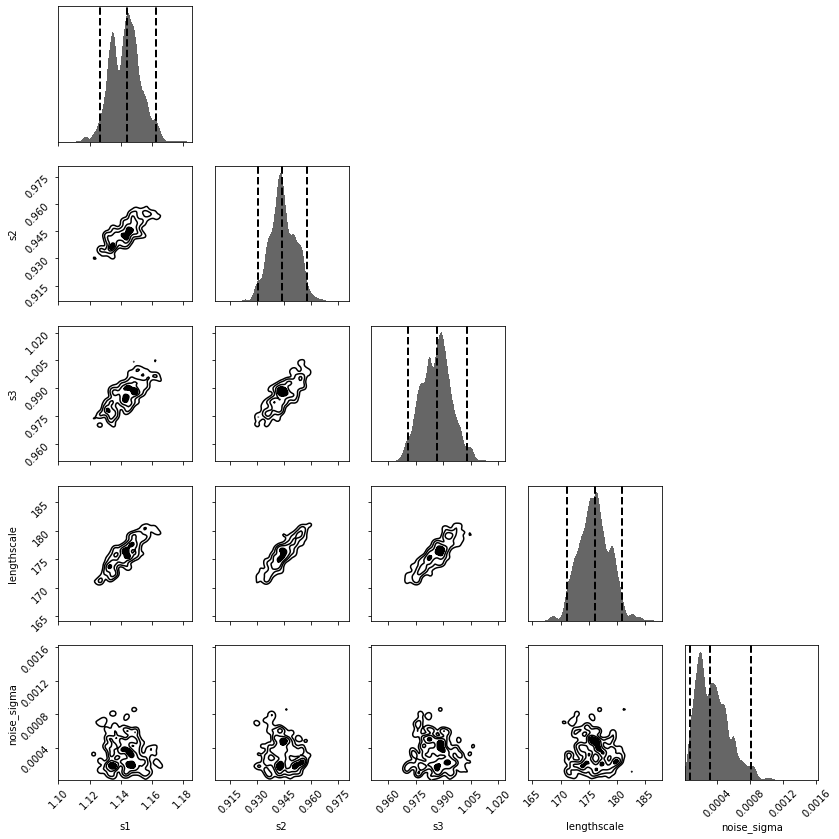

CPU times: user 8.72 s, sys: 1.89 s, total: 10.6 s
Wall time: 6.99 s


In [26]:
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern12Kernel", 23654862, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]119.2s, 2.0min  : Loading run_nested...
Summary
nlive: 25
niter: 857
ncall: 13439
eff(%):  6.563
logz: -443868.740 +/-  1.085


None

'Information (bans)'

12.160931651187159

Quantiles:
s1 [(0.025, 1.389899071330358), (0.5, 1.4100146962688667), (0.975, 1.4278920280406469)]
Quantiles:
s2 [(0.025, 0.8120014589947236), (0.5, 0.8220506273983672), (0.975, 0.8307121167259309)]
Quantiles:
s3 [(0.025, 1.1646184193135938), (0.5, 1.178071199329176), (0.975, 1.197448029520175)]
Quantiles:
lengthscale [(0.025, 15.084133322828995), (0.5, 15.223383768828308), (0.975, 15.39264192357508)]
Quantiles:
noise_sigma [(0.025, 0.008537065943623752), (0.5, 0.008803747385457876), (0.975, 0.00917517858957503)]


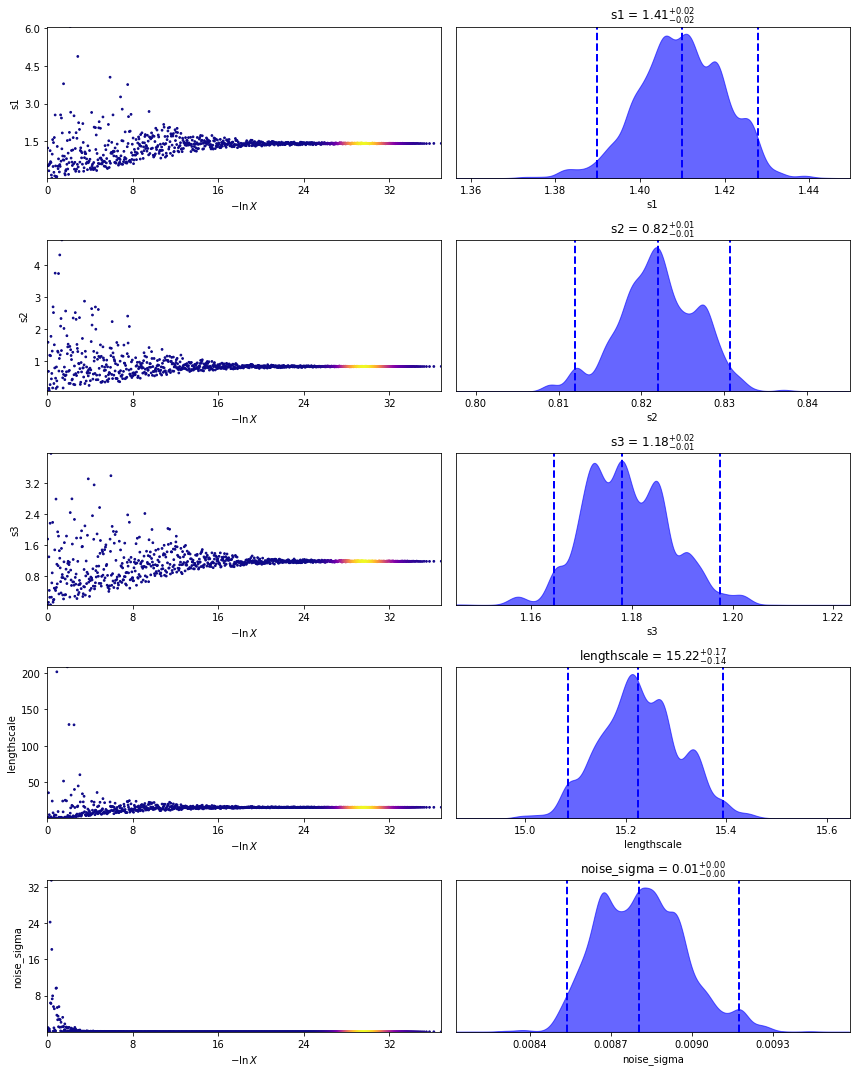

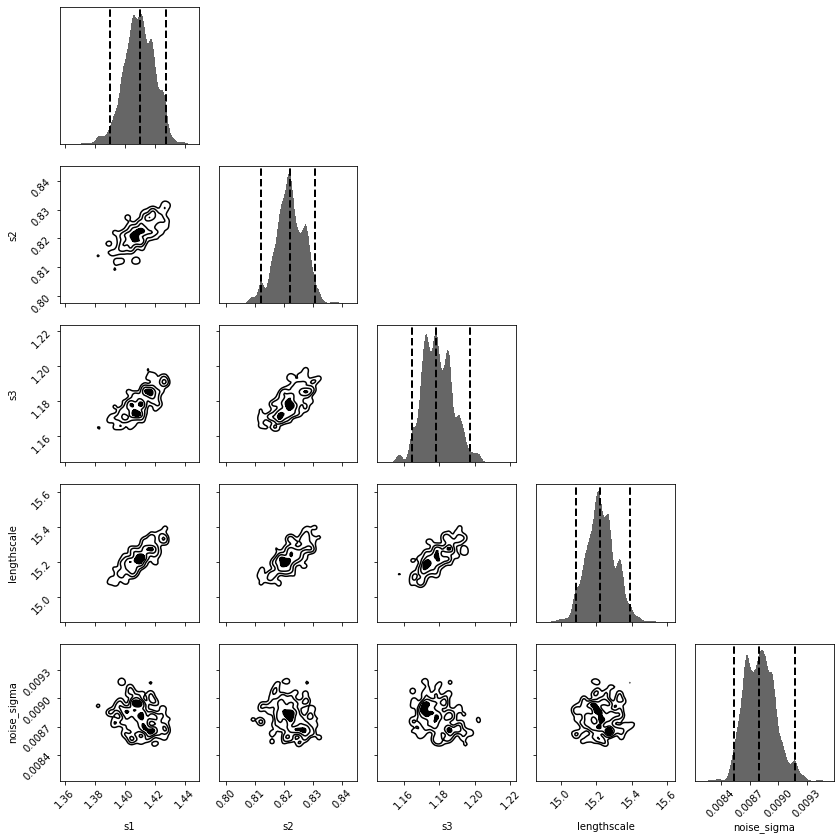

CPU times: user 8.02 s, sys: 1.79 s, total: 9.81 s
Wall time: 6.39 s


In [27]:
%%time
# alternatively cacheid=111111
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern32Kernel", 899785662, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]307.6s, 5.1min  : Loading run_nested...
Summary
nlive: 25
niter: 841
ncall: 14686
eff(%):  5.897
logz: -443868.144 +/-  1.071


None

'Information (bans)'

11.81848570730299

Quantiles:
s1 [(0.025, 1.3896783552848493), (0.5, 1.4083227694387734), (0.975, 1.4273496799810852)]
Quantiles:
s2 [(0.025, 0.8124092721938062), (0.5, 0.8217732100709931), (0.975, 0.8332642791813198)]
Quantiles:
s3 [(0.025, 1.1620895692698674), (0.5, 1.176550360240356), (0.975, 1.195611863214868)]
Quantiles:
lengthscale [(0.025, 15.05609523341872), (0.5, 15.208341927969345), (0.975, 15.380301111398078)]
Quantiles:
noise_sigma [(0.025, 0.00856171648357472), (0.5, 0.00883893154444583), (0.975, 0.009168513713046372)]


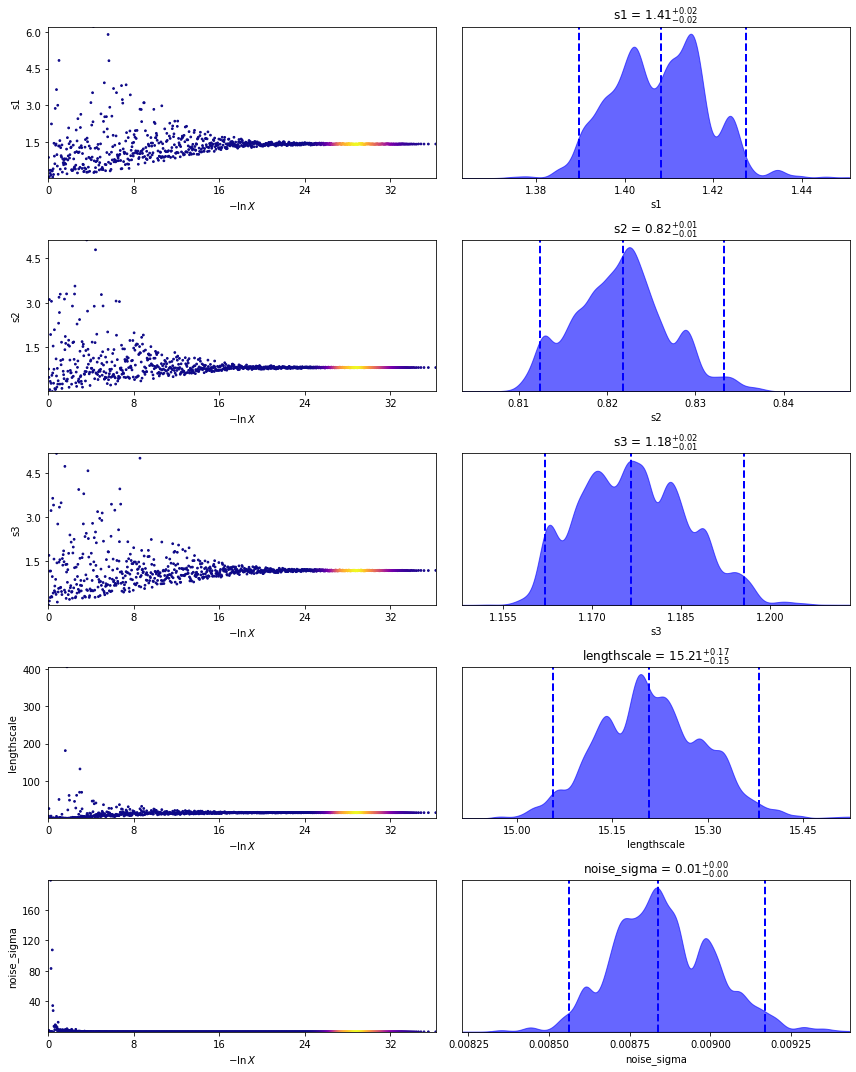

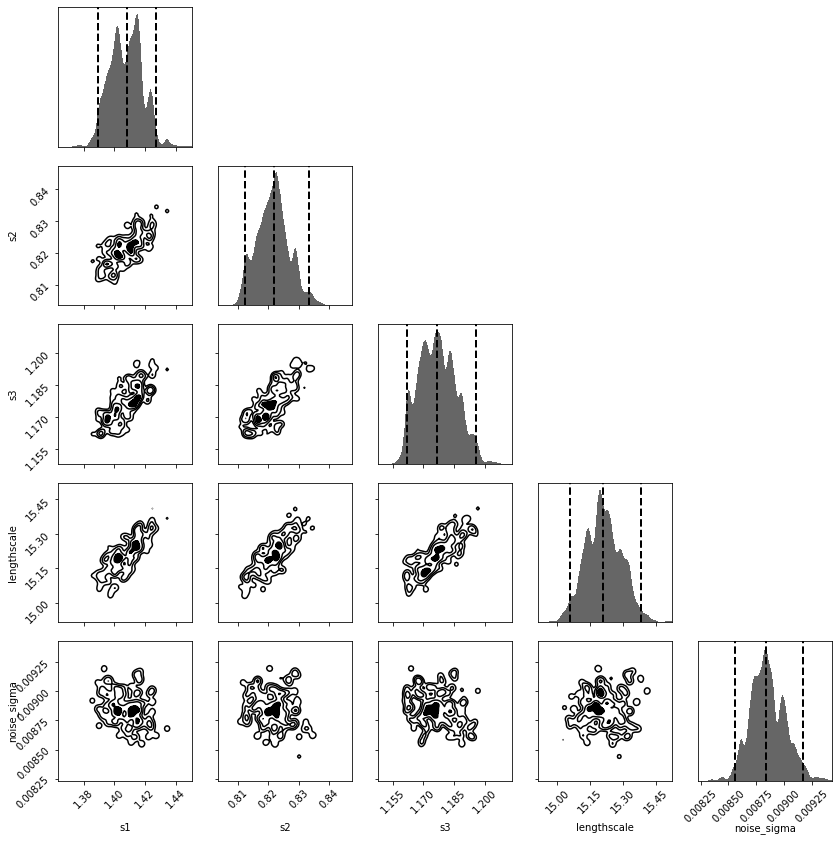

CPU times: user 8.11 s, sys: 1.87 s, total: 9.99 s
Wall time: 6.38 s


In [28]:
# **********************MATERN32 AGAIN**********************
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern32Kernel", 111111, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]397.9s, 6.6min  : Loading run_nested...
Summary
nlive: 25
niter: 851
ncall: 14218
eff(%):  6.161
logz: -447988.917 +/-  1.077


None

'Information (bans)'

11.987647292058154

Quantiles:
s1 [(0.025, 1.2567497983272553), (0.5, 1.2735654439872799), (0.975, 1.2885218821482234)]
Quantiles:
s2 [(0.025, 0.7267436683135456), (0.5, 0.734380108396959), (0.975, 0.7418855956390723)]
Quantiles:
s3 [(0.025, 1.038581543848726), (0.5, 1.052198530217803), (0.975, 1.0672610033870586)]
Quantiles:
lengthscale [(0.025, 8.161982831435074), (0.5, 8.22207516788918), (0.975, 8.278833020462105)]
Quantiles:
noise_sigma [(0.025, 0.017697102997323647), (0.5, 0.017978038909467024), (0.975, 0.018264774814937473)]


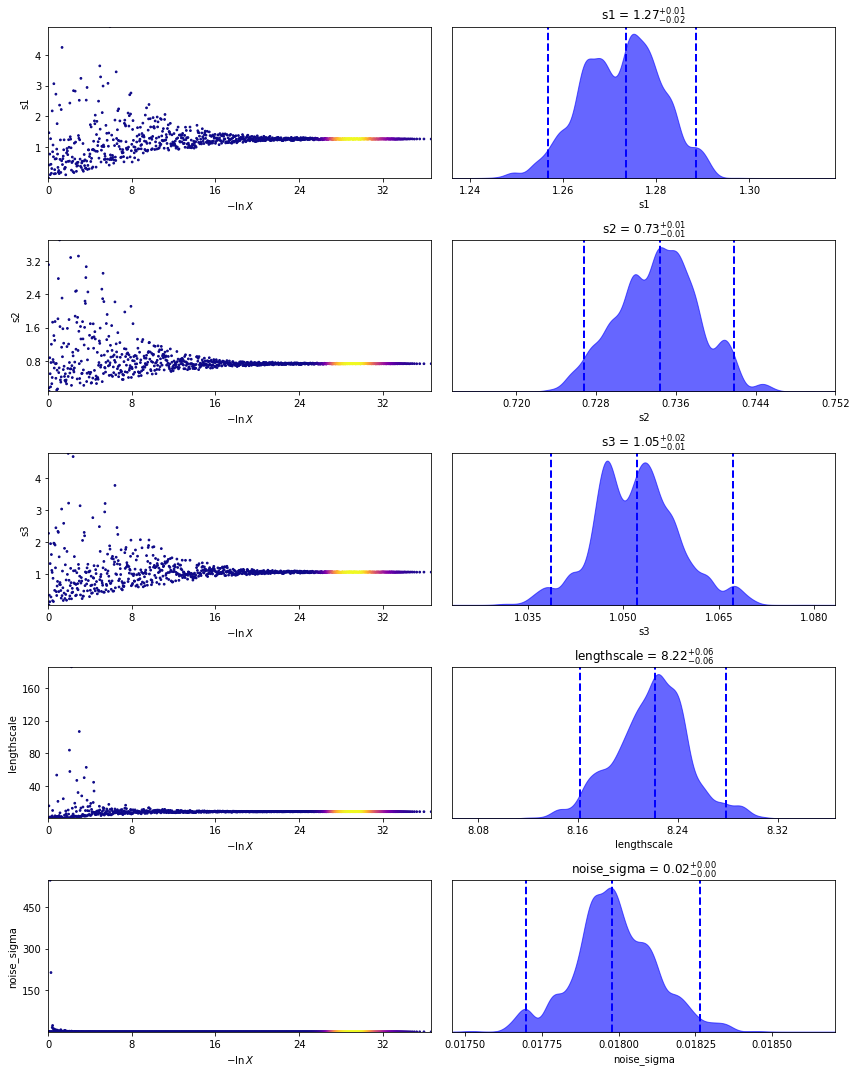

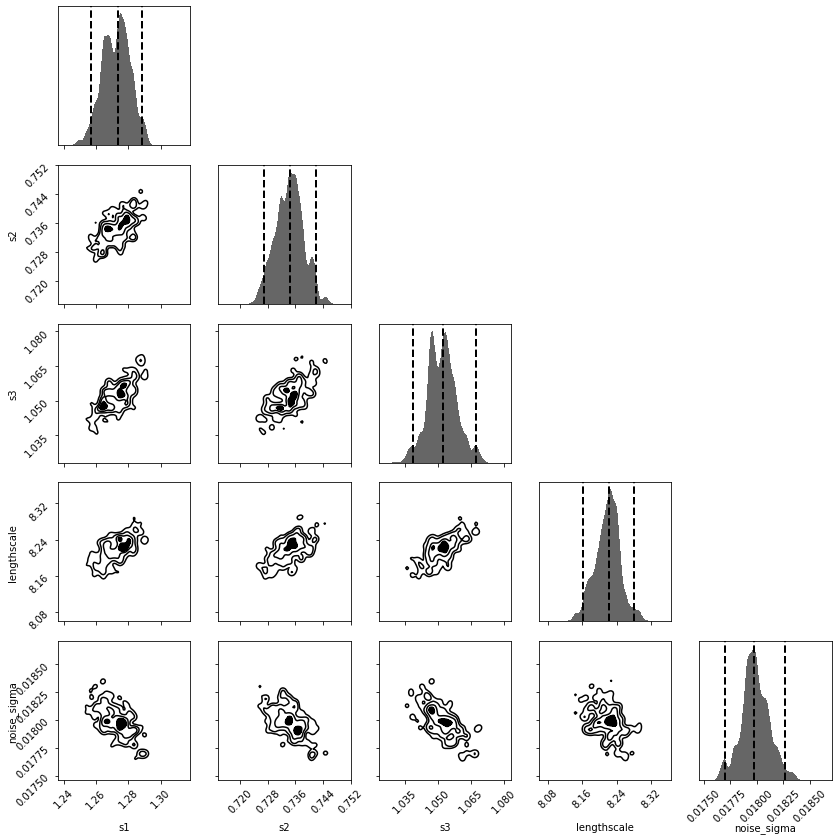

CPU times: user 8.21 s, sys: 1.63 s, total: 9.84 s
Wall time: 6.53 s


In [29]:
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern52Kernel", 17893652, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]451.7s, 7.5min  : Loading run_nested...
Summary
nlive: 25
niter: 871
ncall: 14237
eff(%):  6.293
logz: -464147.140 +/-  1.092


None

'Information (bans)'

12.305801533143152

Quantiles:
s1 [(0.025, 1.1038424626335586), (0.5, 1.1165149474319784), (0.975, 1.1295348103447205)]
Quantiles:
s2 [(0.025, 0.6789729668322098), (0.5, 0.6844284088279794), (0.975, 0.6906518781021824)]
Quantiles:
s3 [(0.025, 0.9893023557261046), (0.5, 1.0010993865615236), (0.975, 1.0126303104962393)]
Quantiles:
lengthscale [(0.025, 4.282314977817972), (0.5, 4.313978912194783), (0.975, 4.350838777676627)]
Quantiles:
noise_sigma [(0.025, 0.029592880147944277), (0.5, 0.0300116597720468), (0.975, 0.030413202366529408)]


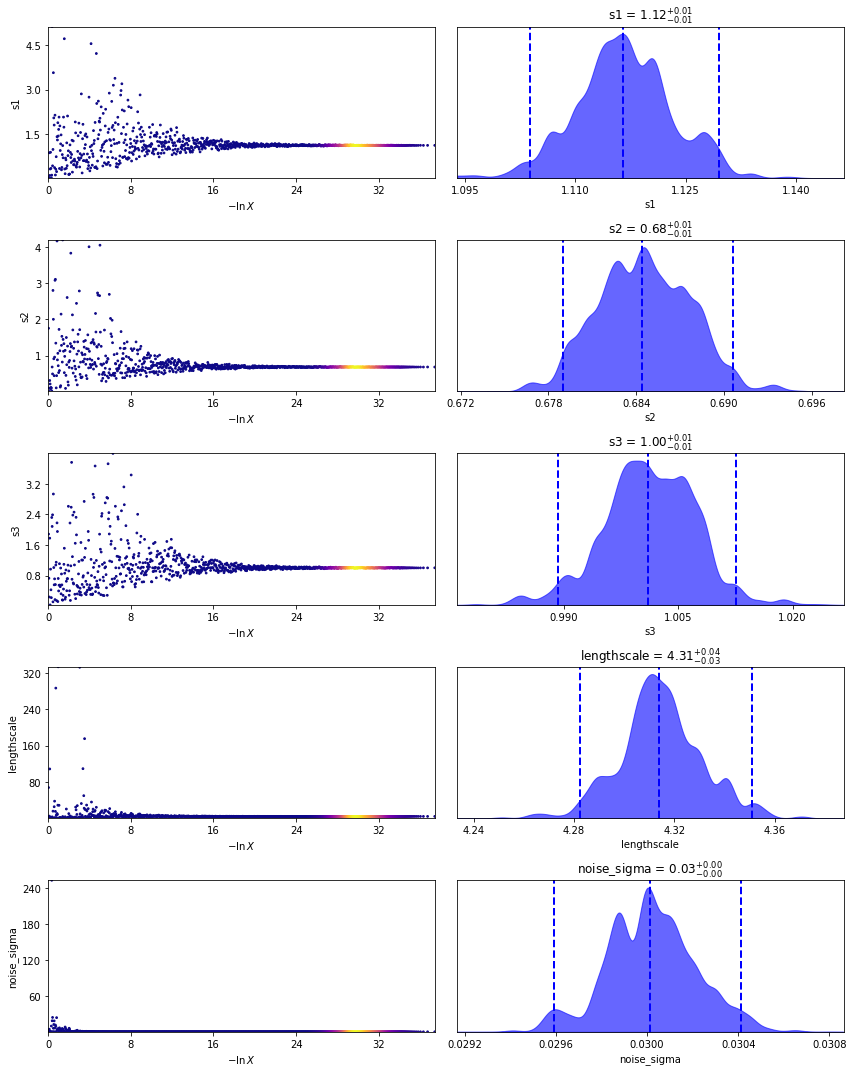

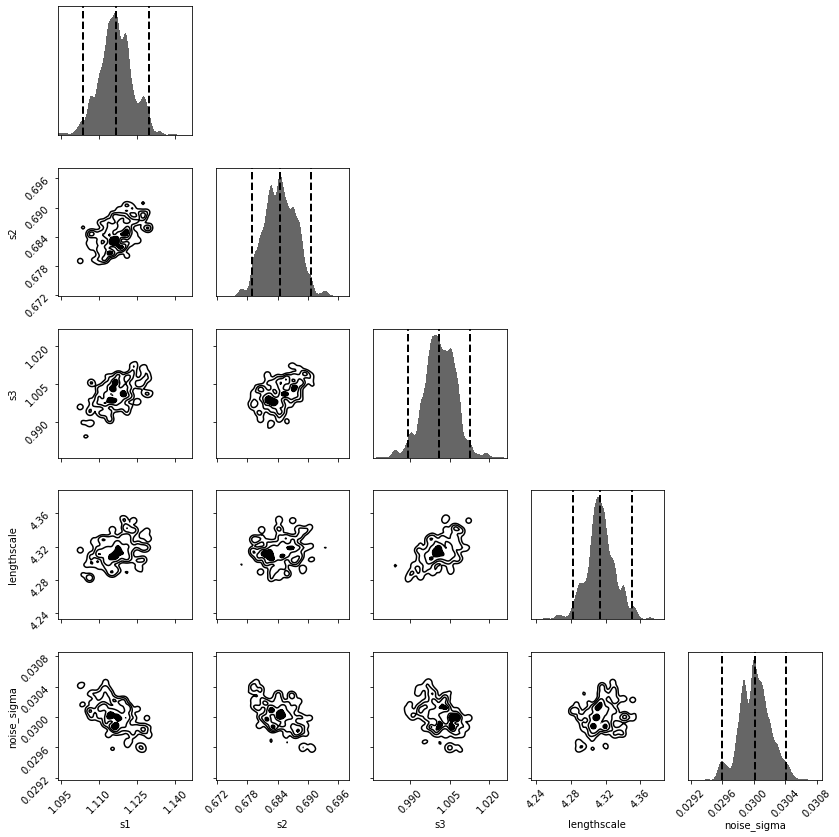

CPU times: user 7.84 s, sys: 1.59 s, total: 9.43 s
Wall time: 6.13 s


In [30]:
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "SqExponentialKernel", 9856723, return_fit_results=True
)
util.dyplot(results, NAMES)